In [5]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pickle
import pandas as pd
import geopandas as gpd


import warnings
warnings.filterwarnings('ignore')


graph_filepath = "../data/iowa.graphml"
towns_cleaned_filepath = "../data/towns_cleaned.pkl"
states_shp_filepath = "../data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
states_map = gpd.read_file(states_shp_filepath)
iowa_map = states_map[states_map.name == 'Iowa']

past_routes = pd.read_csv('../data/past_routes.csv')

with open(towns_cleaned_filepath, "rb") as f:
    towns = pickle.load(f)

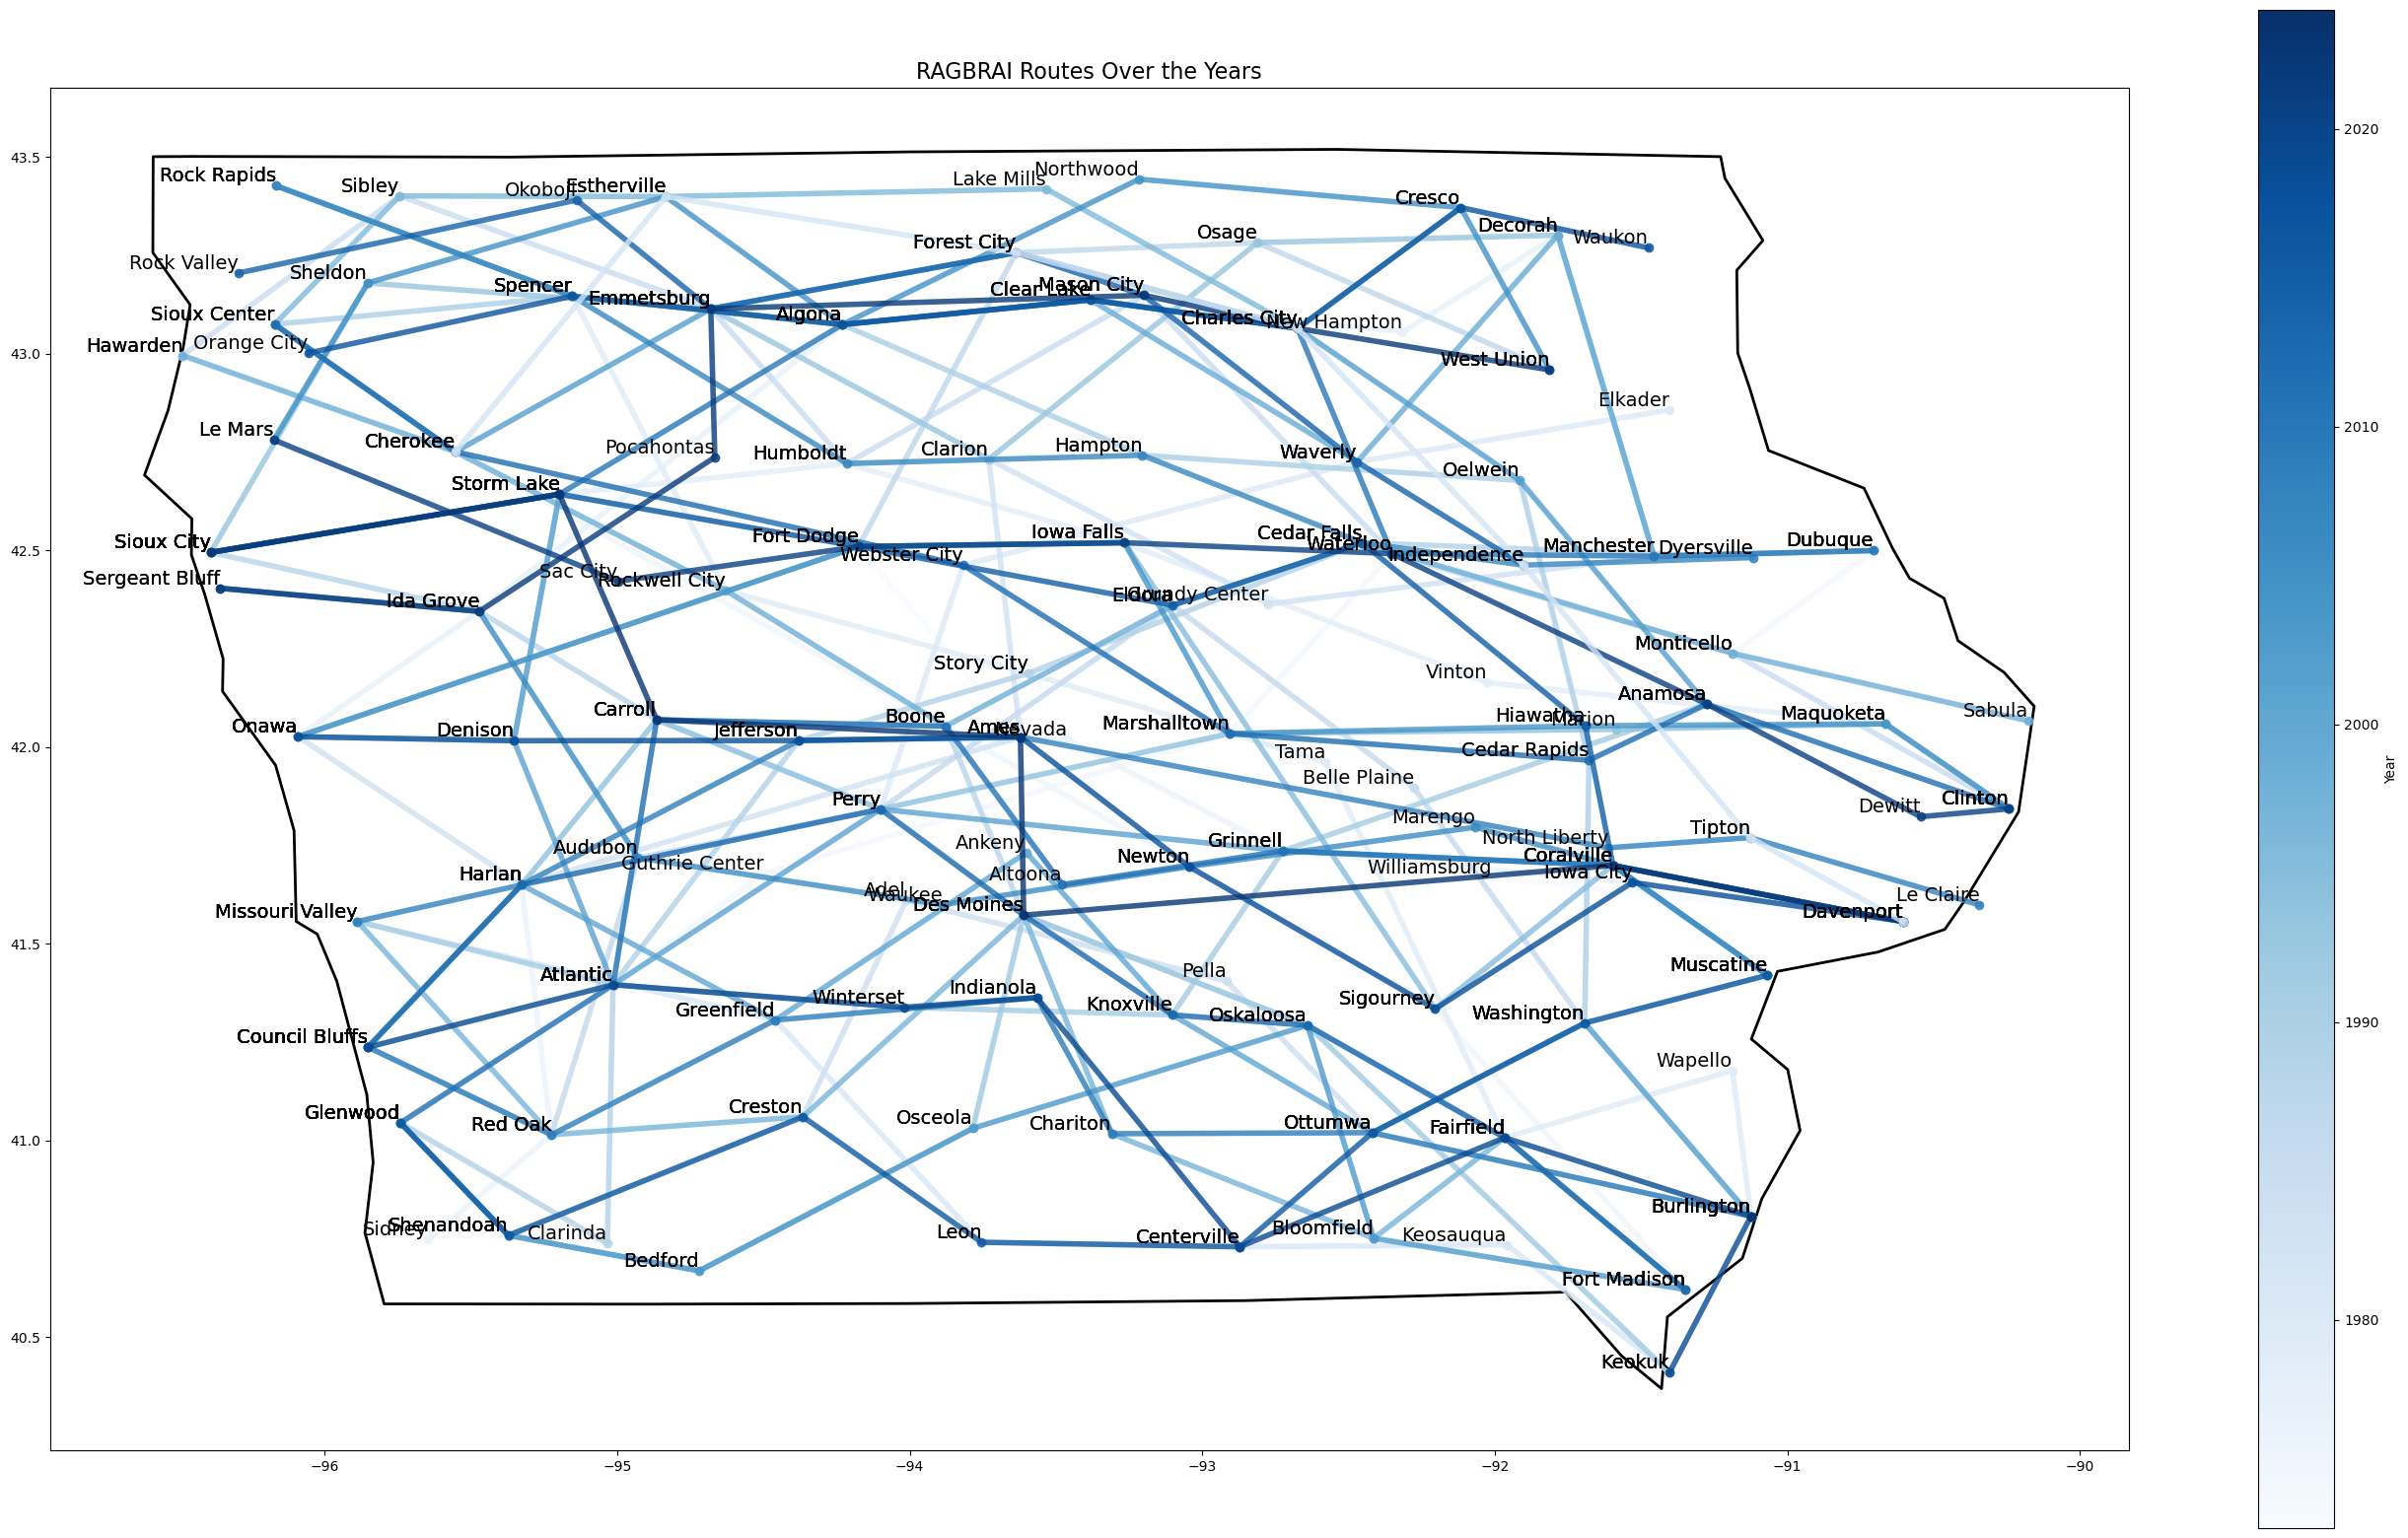

In [49]:
# Columns that represent the days and towns
town_columns = ['Starting Town', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Ending Town']

# Melt the DataFrame to long format
past_routes_long = pd.melt(
    past_routes,
    id_vars=['Year', '#', 'Miles', 'Feet of Climb', 'Riders'],
    value_vars=town_columns,
    var_name='Day',
    value_name='Town'
)

# Drop rows with missing town names
past_routes_long = past_routes_long.dropna(subset=['Town'])

# Convert town names to lowercase
past_routes_long['Town'] = past_routes_long['Town'].str.lower()
towns['name'] = towns['name'].str.lower()
towns['lon'] = towns['centroid'].x
towns['lat'] = towns['centroid'].y

# Merge the DataFrames
merged_df = pd.merge(
    past_routes_long,
    towns[['name', 'centroid', 'lon', 'lat']],
    left_on='Town',
    right_on='name',
    how='left'
)

# Drop rows where the centroid is missing (town not found in towns_unique)
merged_df = merged_df.dropna(subset=['centroid'])

# Plot the Iowa map
fig, ax = plt.subplots(figsize=(34, 20))
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')

# Define a colormap ranging from grey to blue
years = merged_df['Year'].unique()
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))  # Normalize years to the colormap range
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')

for year in years:
    year_data = merged_df[merged_df['Year'] == year]
    # Sort by Day to maintain the route order
    day_order = ['Starting Town', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Ending Town']
    year_data['Day'] = pd.Categorical(year_data['Day'], categories=day_order, ordered=True)
    year_data = year_data.sort_values('Day')
    
    # Map the year to the colormap
    color = cmap.to_rgba(year)
    
    # Plot the route
    ax.plot(year_data['lon'], year_data['lat'], marker='o', label=f"Year {year}", color=color, alpha=.8, linewidth=4)
    
    # Annotate the towns
    for x, y, label in zip(year_data['lon'], year_data['lat'], year_data['Town'].str.title()):
        ax.text(x, y, label, fontsize=14, ha='right', va='bottom')

plt.title("RAGBRAI Routes Over the Years", fontsize=16)
# Add a colorbar to show the year gradient
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Blues'), ax=ax)
cbar.set_label('Year')

plt.show()


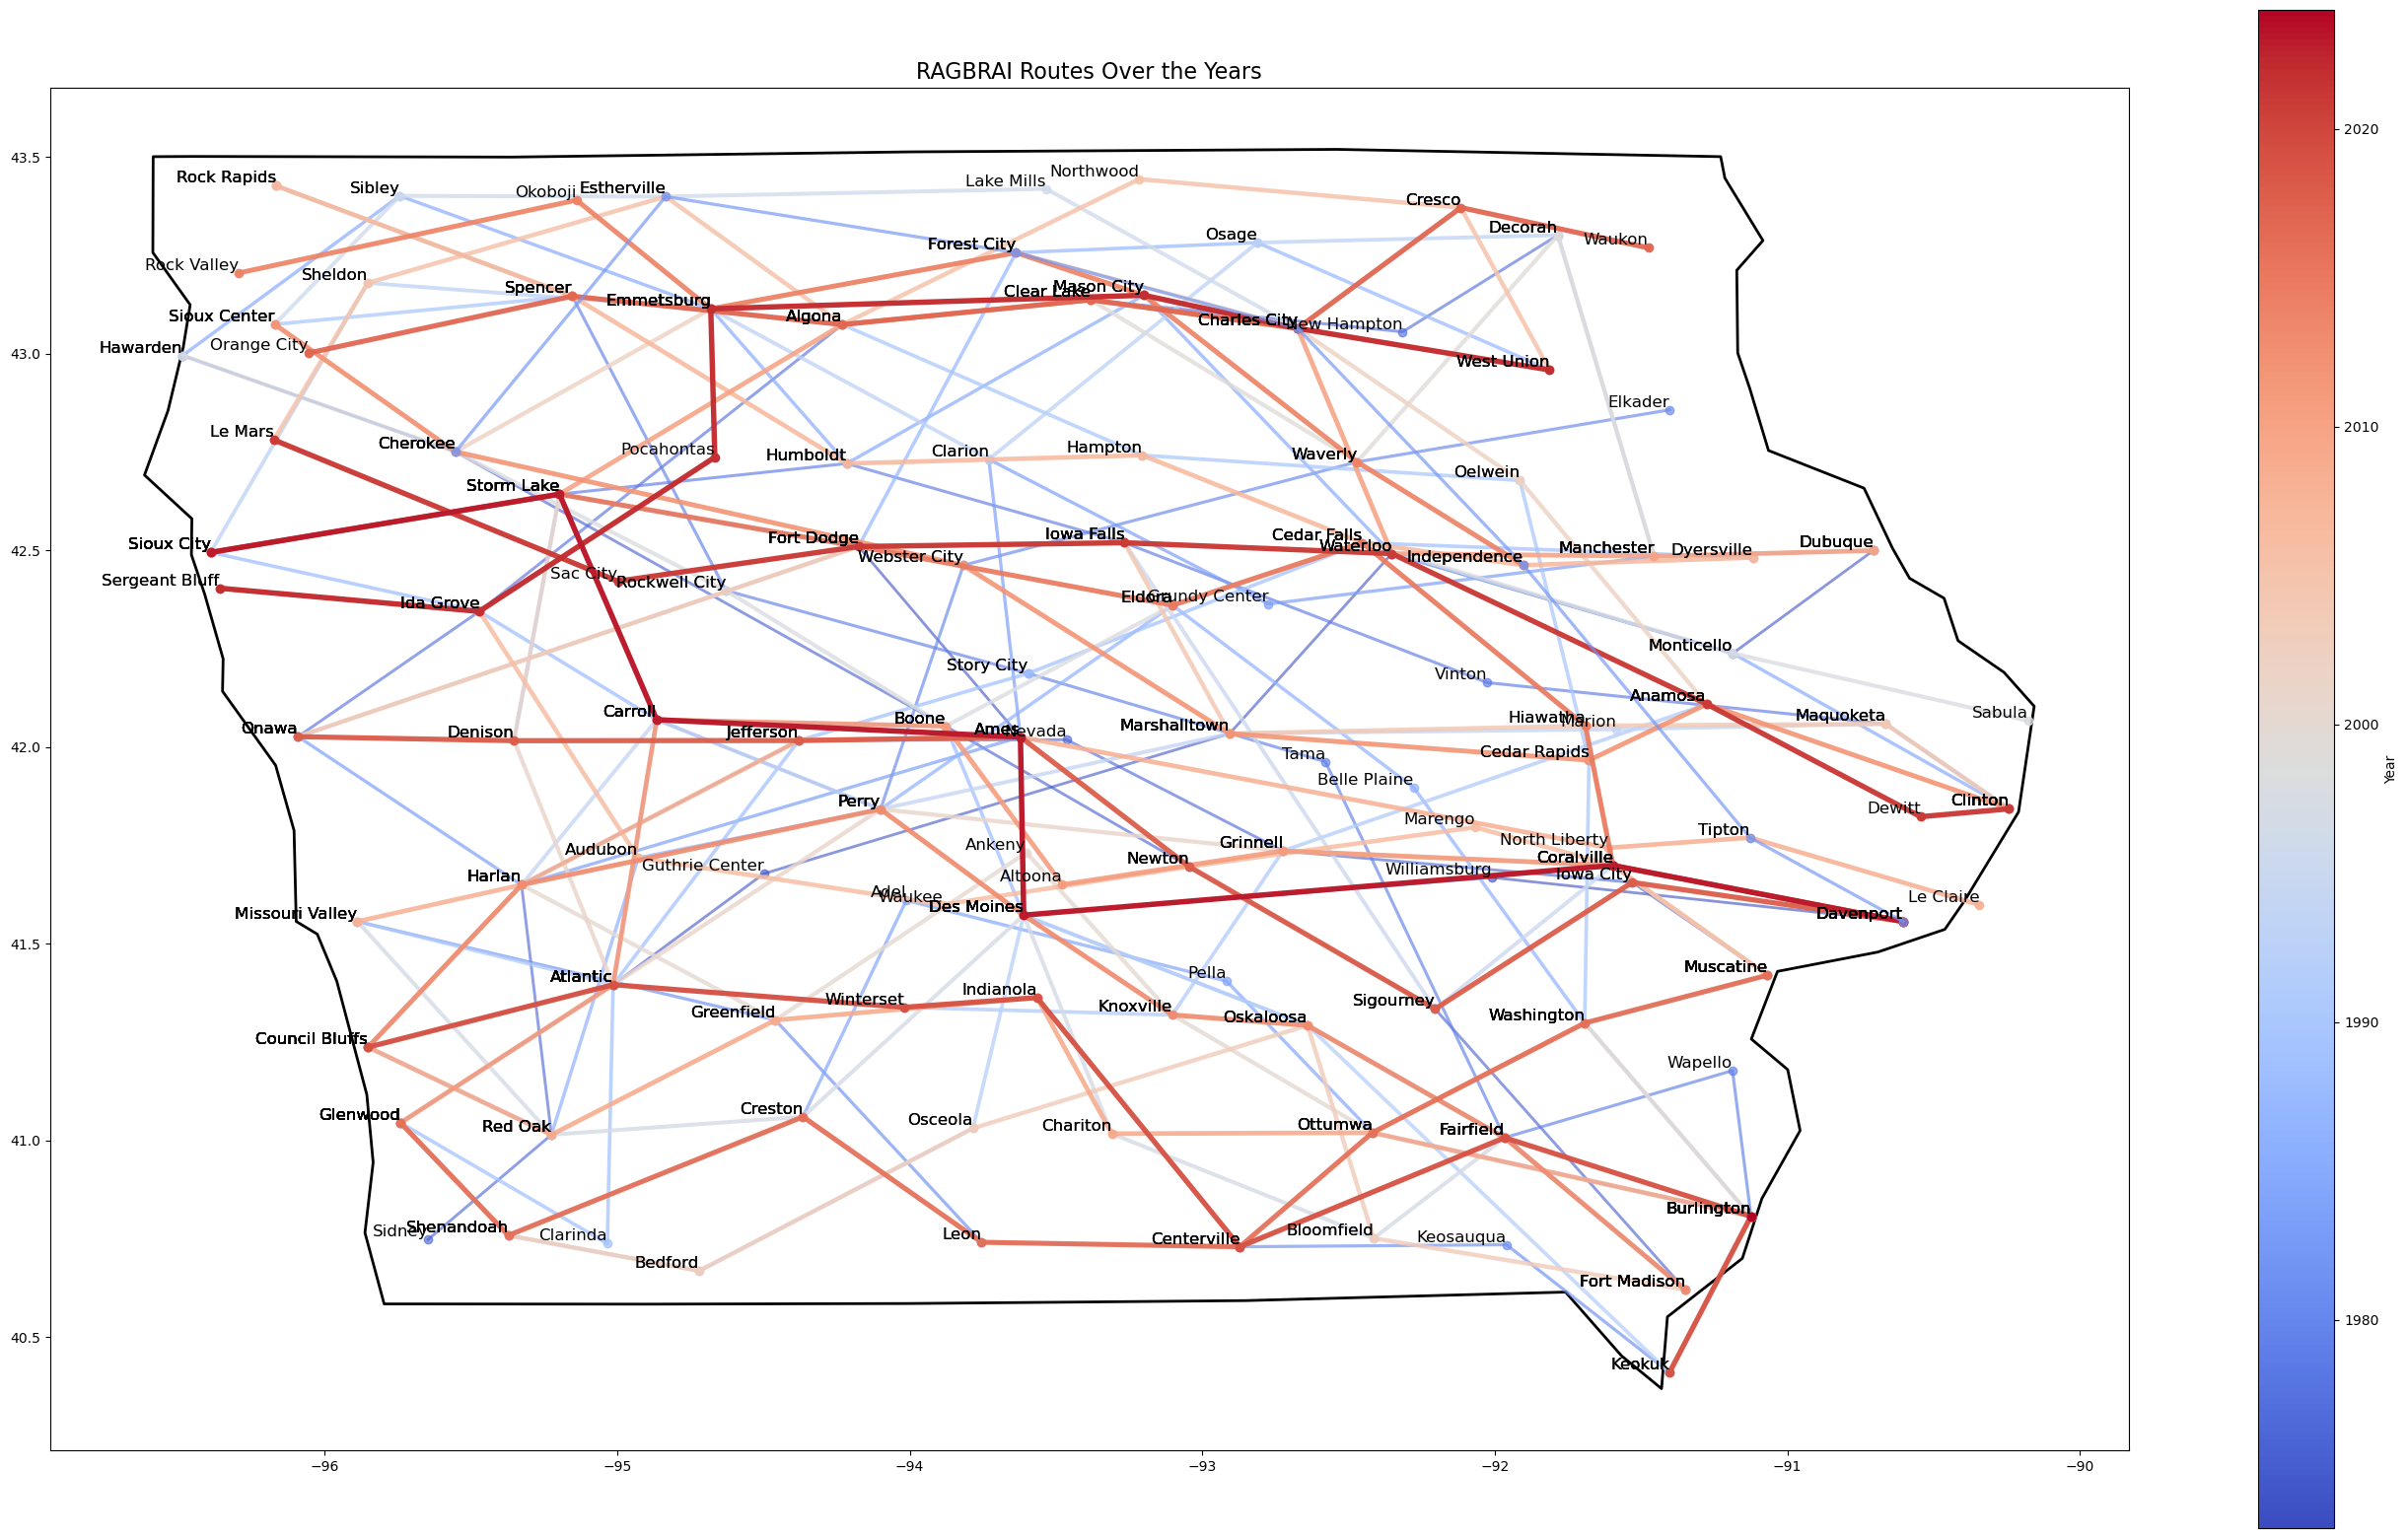

In [57]:
# Plot the Iowa map
fig, ax = plt.subplots(figsize=(34, 20))
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')

# Define a colormap and normalization
cmap = cm.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))

# Scale for line width and alpha
line_widths = (merged_df['Year'] - min(years)) / (max(years) - min(years)) * 3 + 1
alpha_values = (merged_df['Year'] - min(years)) / (max(years) - min(years)) * 0.5 + 0.5

for year in years:
    year_data = merged_df[merged_df['Year'] == year]
    year_data['Day'] = pd.Categorical(year_data['Day'], categories=day_order, ordered=True)
    year_data = year_data.sort_values('Day')

    # Map year to color, line width, and alpha
    color = cmap(norm(year))
    line_width = 2 + (year - min(years)) / (max(years) - min(years)) * 2
    alpha = 0.6 + (year - min(years)) / (max(years) - min(years)) * 0.4

    ax.plot(year_data['lon'], year_data['lat'], marker='o', color=color, alpha=alpha, linewidth=line_width, label=f"{year}")

    # Town Annotations
    for x, y, label in zip(year_data['lon'], year_data['lat'], year_data['Town'].str.title()):
        ax.text(x, y, label, fontsize=12, ha='right', va='bottom')

# Colorbar
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Year')
plt.title("RAGBRAI Routes Over the Years", fontsize=16)
plt.show()